In [1]:
import os
import numpy as np
import rosbag
import matplotlib.pyplot as plt
import custom_utils.data_conversion as data_conversion

DATAFILE = "/scratchdata/ceiling"

In [2]:
# Open bag file
bag_file_path = os.path.join(DATAFILE, "raw.bag")
bag = rosbag.Bag(bag_file_path)

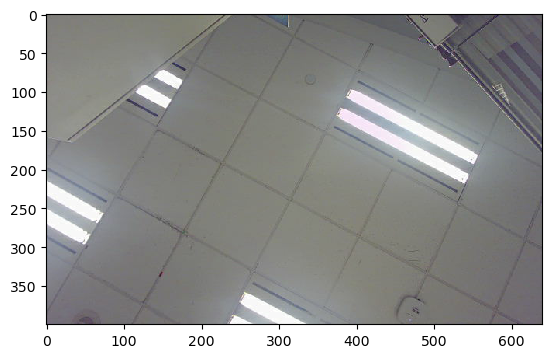

In [3]:
wait = 0
for topic, msg, t in bag.read_messages(topics=["/camera/color/image_raw"]):
    wait += 1
    if wait == 5:
        img = data_conversion.topic_to_image(msg)
        break

plt.imshow(img)

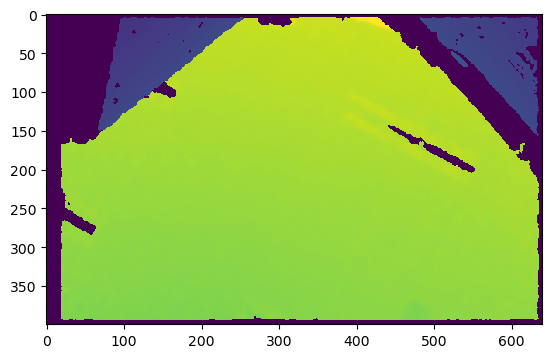

In [4]:
wait = 0

for topic, msg, t in bag.read_messages(topics=["/camera/depth/image_raw"]):
    wait += 1
    if wait == 5:
        depth = data_conversion.topic_to_depth(msg)
        break

plt.imshow(depth.reshape((depth.shape[0], depth.shape[1])))

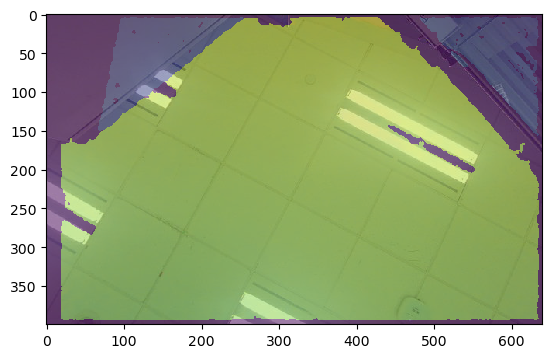

In [5]:
# Overlay image overdepth at half alpha
plt.imshow(depth.reshape((depth.shape[0], depth.shape[1])))
plt.imshow(img, alpha=0.5)

In [7]:
import os
os.chdir("/Depth-Anything-V2")
print(os.getcwd())

import cv2
import torch

from depth_anything_v2.dpt import DepthAnythingV2

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vitl' # or 'vits', 'vitb', 'vitg'

model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'/scratchdata/depth_anything_v2_vitl.pth', map_location='cpu'))
model = model.to(DEVICE).eval()

depth = model.infer_image(np.array(img)) # HxW raw depth map in numpy


/Depth-Anything-V2


/tmp/ipykernel_23530/2547968482.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'/scratchdata/depth_anything_v2_vitl.pth', map_locatio

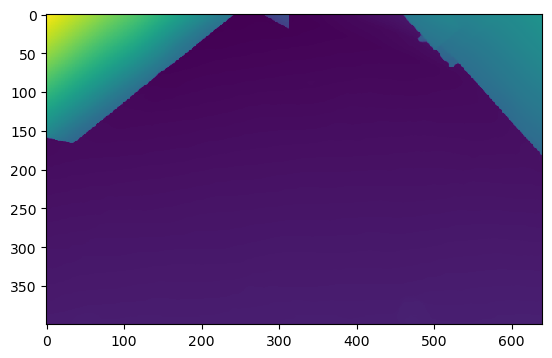

In [8]:
plt.imshow(depth)